In [1]:
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from functools import lru_cache

from dotless_arabic.processing import undot

In [2]:
def tokens_counter(tokenizer_name,is_dotted=True,dataset_name='aggregated'):
    # loading the tokens frequency json file
    if is_dotted is True:
        counts_file_name = f'dotted_{tokenizer_name}.json'
    else:
        counts_file_name = f'undotted_{tokenizer_name}.json'
    counts_file_path = f'dotless_arabic/datasets/{dataset_name}/tokens_count/{counts_file_name}'
    counter = json.load(open(counts_file_path))
    return counter

In [3]:
# in this notebook, we will only consider the aggregated dataset as it holds all tokens
words_counter = tokens_counter(tokenizer_name='WordTokenizer')
farasa_counter = tokens_counter(tokenizer_name='FarasaMorphologicalTokenizer')
disjoint_counter = tokens_counter(tokenizer_name='DisjointLetterTokenizer')


In [10]:
@lru_cache()
def get_x_y_points(counter_json_str,verbose=True,maximum_percentage=100,use_tqdm=True):
    counter = json.loads(counter_json_str)
    assert 2 <= maximum_percentage <=100 , f'maximum percentage should be between 2,100'
    thresholds = list(map(lambda item: round(0.01*item,2), range(1,maximum_percentage)))
    words = list(counter.keys())
    X,Y = list(),list()
    thresholds = tqdm(thresholds) if use_tqdm else thresholds
    for threshold in thresholds:
        top_words = words[:int(threshold*len(words))]
        words_size = len(top_words)
        undotted_words = list(map(lambda word: undot(word,process_first=True),top_words))
        undotted_words_size = len(set(undotted_words))
        reduction_ratio = 1-(undotted_words_size/words_size)
        X.append(threshold)
        Y.append(round(100*reduction_ratio,2))
        if verbose:
            print(
                f'top {int(threshold*100)}% words: {words_size:,}',
                f'undotted: {undotted_words_size:,}',
                f'reduction ratio: {round(100*reduction_ratio,2):,}%',
                )
    return X,Y

In [11]:

# testing the function
get_x_y_points(counter_json_str=json.dumps(disjoint_counter),maximum_percentage=10)

  0%|          | 0/9 [00:00<?, ?it/s]

top 1% words: 4,020 undotted: 2,801 reduction ratio: 30.32%
top 2% words: 8,040 undotted: 5,467 reduction ratio: 32.0%
top 3% words: 12,060 undotted: 8,038 reduction ratio: 33.35%
top 4% words: 16,080 undotted: 10,609 reduction ratio: 34.02%
top 5% words: 20,100 undotted: 13,088 reduction ratio: 34.89%
top 6% words: 24,121 undotted: 15,605 reduction ratio: 35.31%
top 7% words: 28,141 undotted: 17,998 reduction ratio: 36.04%
top 8% words: 32,161 undotted: 20,436 reduction ratio: 36.46%
top 9% words: 36,181 undotted: 22,794 reduction ratio: 37.0%


([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09],
 [30.32, 32.0, 33.35, 34.02, 34.89, 35.31, 36.04, 36.46, 37.0])

In [12]:
def plot(
    counters=[
        words_counter,
        farasa_counter,
        disjoint_counter,
    ],
    counters_names=[
        'words',
        'farasa subwords',
        'disjoint subwords'
    ]
):
    plt.figure(figsize=(15,10),dpi=300)
    for counter,counter_name in list(zip(counters,counters_names)):
        X,Y = get_x_y_points(counter_json_str=json.dumps(counter),verbose=False)
        plt.plot(
            X,
            Y,
            label=f'{counter_name}',
        )
    plt.xlabel('words',fontsize=15)
    plt.ylabel('dotless words ratio',fontsize=15,)
    plt.legend(loc='upper right',fontsize=15)

In [13]:
plot()

  0%|          | 0/99 [00:00<?, ?it/s]

In [8]:
def plot_multiple(
    counters=[
        words_counter,
        disjoint_counter,
        farasa_counter,
    ],
    counters_names=[
        'words',
        'disjoint subwords',
        'farasa subwords',
    ]
):
    plt.rc('font',size=15)
    figure, axis = plt.subplots(1,3,figsize=(30,10),layout='constrained',dpi=300)
    for i,(counter,counter_name) in enumerate(list(zip(counters,counters_names))):
        X,Y = get_x_y_points(counter_json_str=json.dumps(counter),verbose=False)
        axis[i].plot(
            X,
            Y,
            label=f'{counter_name}',
        )
        axis[i].legend(loc='upper right',fontsize=15)
        
    figure.supxlabel('words',fontsize=15)
    figure.supylabel('dotless words ratio',fontsize=15)

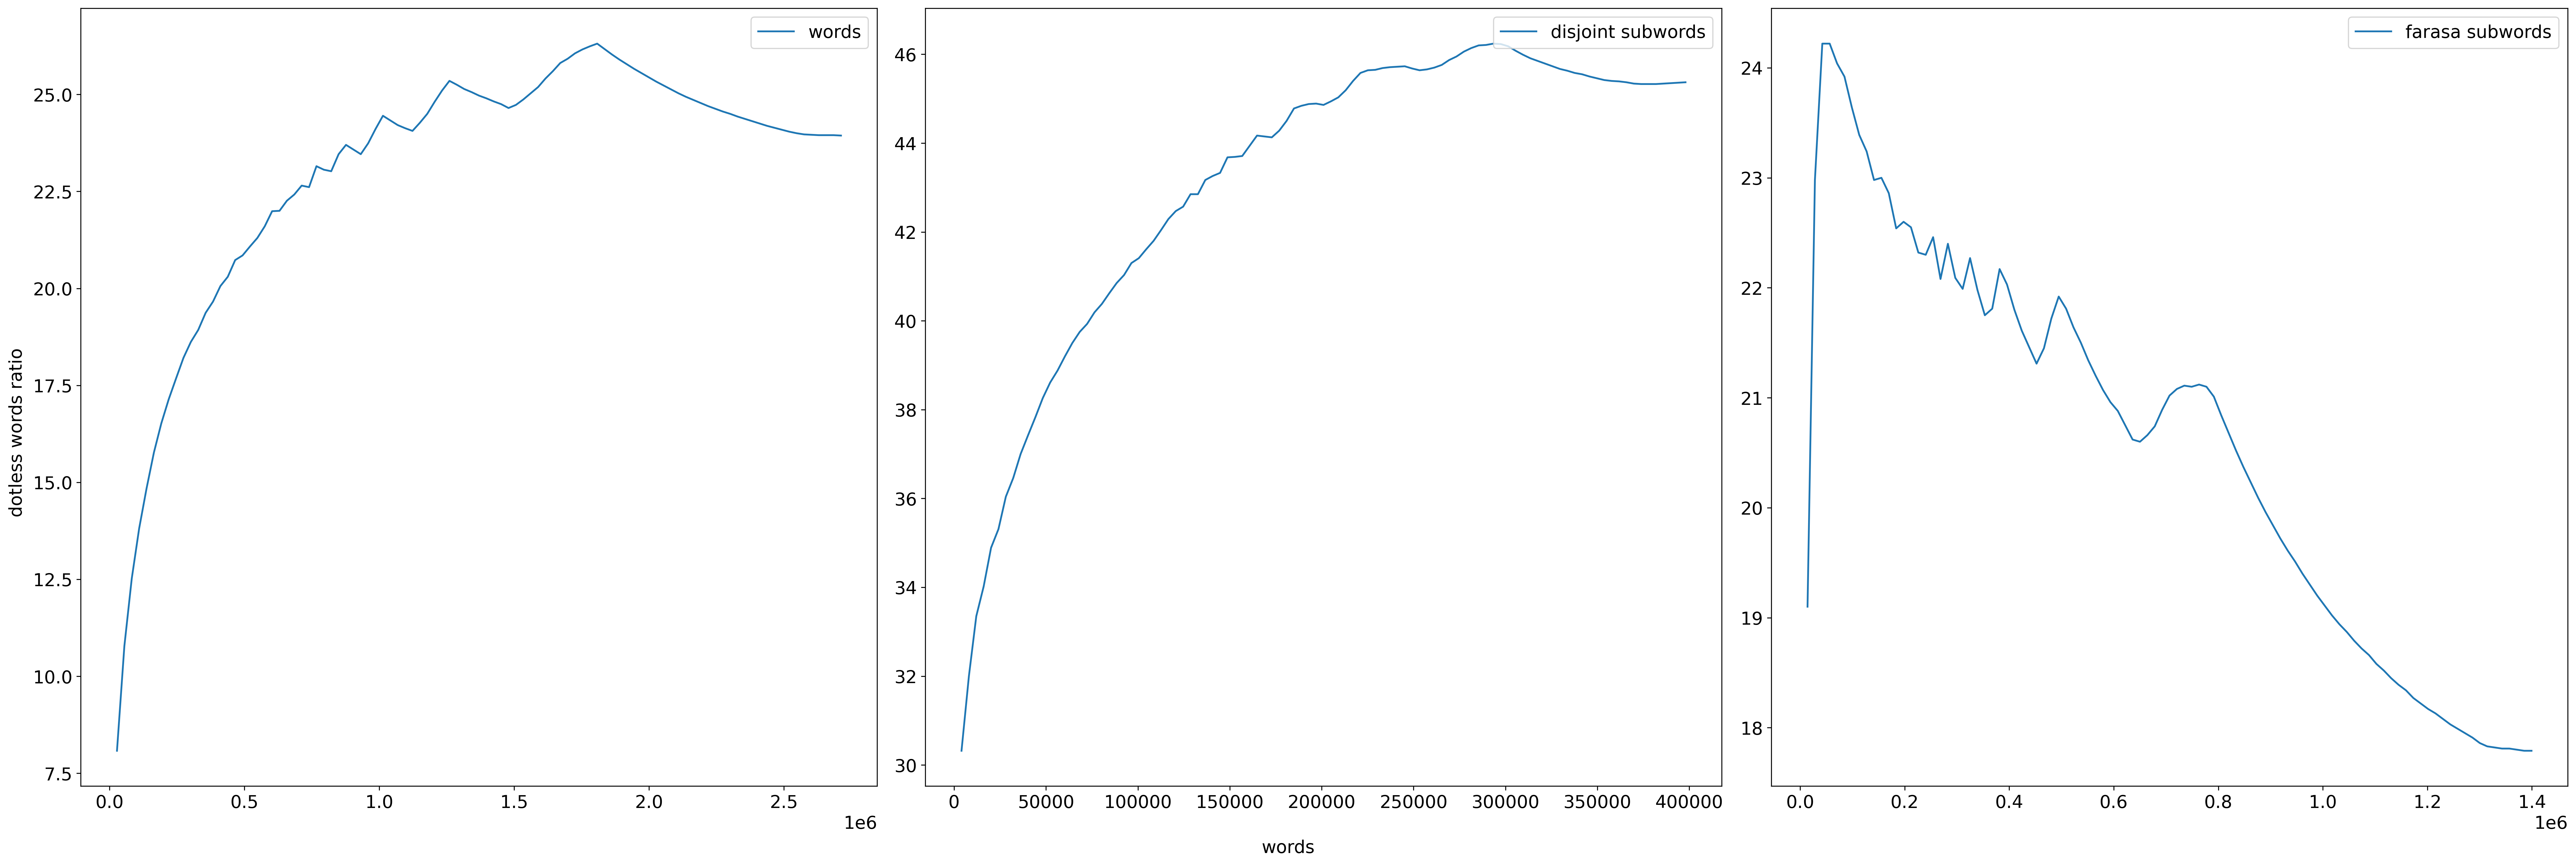

In [9]:
plot_multiple()